# Testing

### Make Forward

### Setup

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import coherence, unit_impulse, welch

import mne
from mne.beamformer import apply_dics_csd, make_dics
from mne.datasets import sample, fetch_fsaverage
from mne.minimum_norm import apply_inverse, make_inverse_operator, read_inverse_operator
from mne.simulation import add_noise, simulate_raw
from mne.time_frequency import csd_morlet

""" Simulation Setup """
snr = 20.0
signal_num = 20

""" Tutorial """
# We use the MEG and MRI setup from the MNE-sample dataset
# data_path = sample.data_path(download=False)
# subjects_dir = data_path / "subjects"
# subject = "fsaverage"
# # Filenames for various files we'll be using
# meg_path = data_path / "MEG" / "sample"
# raw_fname = meg_path / "sample_audvis_raw.fif"
# fwd_fname = meg_path / "sample_audvis-eeg-oct-6-fwd.fif"
# cov_fname = meg_path / "sample_audvis-cov.fif"
# fwd = mne.read_forward_solution(fwd_fname, verbose='WARNING')

""" Customize """
data_path = sample.data_path(download=False)
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir
raw_fname = './test_raw.fif'
fwd_fname = './test-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)

# Seed for the random number generator
rand = np.random.RandomState(42)

0 files missing from root.txt in C:\Users\richi\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage
Reading forward solution from h:\共用雲端硬碟\CNElab_陳昱祺\source localization\simulate_data\test-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (20484 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


### Data Simulation

#### Signal Generation

In [2]:
sfreq = 100.0
n = 2.0
n_samp = int(round(n * sfreq))

def coh_signal_gen(base_freq = 10.0, sfreq = 100.0, n_samp = 200):
    """Generate an oscillating signal.
    Inputs:
        base_frq: base freqency for simulation
        sfreq: sampling freqency
        n: sampling times (seconds)

    Returns
    -------
    signal : ndarray
        The generated signal.
    """
    
    times = np.arange(n_samp) / sfreq  # 10 seconds of signal

    t_rand = 0.001  # Variation in the instantaneous frequency of the signal
    std = 0.1  # Std-dev of the random fluctuations added to the signal
    n_times = len(times)

    # Generate an oscillator with varying frequency and phase lag.
    signal = np.sin(
        2.0
        * np.pi
        * (
            base_freq * np.arange(n_times) / sfreq
            + np.cumsum(t_rand * rand.randn(n_times))
        )
    )

    # Add some random fluctuations to the signal.
    signal += std * rand.randn(n_times)

    # Scale the signal to be in the right order of magnitude (~100 nAm)
    # for MEG data.
    signal *= 20e-9

    return signal

#### Get Label Info

In [3]:
labels = mne.read_labels_from_annot("", subjects_dir=subjects_dir)
labels = labels[:-1]
label_names = [label.name for label in labels] 

labels_central_list = []

hemi_to_ind = {"lh": 0, "rh": 1}
for i, label in enumerate(labels):
    # The `center_of_mass` function needs labels to have values.
    labels[i].values.fill(1.0)
    print(label)
    # Restrict the eligible vertices to be those on the surface under
    # consideration and within the label.
    surf_vertices = fwd["src"][hemi_to_ind[label.hemi]]["vertno"]
    restrict_verts = np.intersect1d(surf_vertices, label.vertices)
    com = labels[i].center_of_mass(
        subjects_dir=subjects_dir, restrict_vertices=restrict_verts, surf="white"
    )
    
    # Convert the center of vertex index from surface vertex list to Label's
    # vertex list.
    cent_idx = np.where(label.vertices == com)[0][0]

    labels_central_list.append(labels[i].vertices[cent_idx])


Reading labels from parcellation...
   read 35 labels from C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
<Label | , 'bankssts-lh', lh : 2137 vertices>
<Label | , 'bankssts-rh', rh : 2196 vertices>
<Label | , 'caudalanteriorcingulate-lh', lh : 1439 vertices>
<Label | , 'caudalanteriorcingulate-rh', rh : 1608 vertices>
<Label | , 'caudalmiddlefrontal-lh', lh : 3736 vertices>
<Label | , 'caudalmiddlefrontal-rh', rh : 3494 vertices>
<Label | , 'cuneus-lh', lh : 1630 vertices>
<Label | , 'cuneus-rh', rh : 1638 vertices>
<Label | , 'entorhinal-lh', lh : 1102 vertices>
<Label | , 'entorhinal-rh', rh : 902 vertices>
<Label | , 'frontalpole-lh', lh : 272 vertices>
<Label | , 'frontalpole-rh', rh : 369 vertices>
<Label | , 'fusiform-lh', lh : 4714 vertices>
<Label | , 'fusiform-rh', rh : 4661 vertices>
<Label | , 'inferiorparietal-lh', lh : 7871 vertices>
<Label | , 'infer

#### Srouce Signal Generation

In [4]:
import numpy as np
import mne

def stc_signal_gen(signal_num=2, sfreq=100.0):
    vertices = [[], []]  # 左半球、右半球的頂點索引
    data = []
    simu_freq = []

    hemi_index = {'lh': 0, 'rh': 1}  # 左/右半球索引對應
    
    # **確保選擇的頂點不重複**
    selected_vertices = set()  # 用來追蹤已選過的頂點

    for signal_index in range(signal_num):
        rand_freq = np.random.randint(1, 31)  # 避免 0 Hz
        simu_freq.append(rand_freq)
        print("rand freq:", rand_freq)
        
        # **隨機選擇一個未被選擇過的頂點**
        unused_vertices = list(set(labels_central_list) - selected_vertices)

        label_vertex = np.random.choice(unused_vertices)
        label_index = labels_central_list.index(label_vertex)
        hemi = labels[label_index].hemi  # 取得半球資訊
        selected_vertices.add(label_vertex)  # 加入已選清單
        
        print("Hemisphere:", hemi)
        print("Selected Vertex:", label_vertex)

        # 產生信號
        signal = coh_signal_gen(rand_freq)

        # 加入對應的半球
        vertices[hemi_index[hemi]].append(label_vertex)
        data.append(signal)

    # **確保 `vertices` 內的頂點是遞增排序的，並轉換成 numpy array**
    vertices[0] = np.array(sorted(vertices[0]), dtype=np.int64)  # 左半球
    vertices[1] = np.array(sorted(vertices[1]), dtype=np.int64)  # 右半球

    # **確保 `vertices` 不是空陣列**
    if len(vertices[0]) == 0:
        vertices[0] = np.array([], dtype=np.int64)
    if len(vertices[1]) == 0:
        vertices[1] = np.array([], dtype=np.int64)

    # **確保 `data` 是 numpy array，並檢查形狀**
    data = np.array(data)

    print("Final vertices (LH):", vertices[0])
    print("Final vertices (RH):", vertices[1])
    print("Data shape:", data.shape)

    # **檢查 `data.shape[0]` 是否等於 `len(vertices[0]) + len(vertices[1])`**
    expected_sources = len(vertices[0]) + len(vertices[1])
    if data.shape[0] != expected_sources:
        raise ValueError(f"Mismatch: data.shape[0]={data.shape[0]}, but expected {expected_sources}")

    # **建立 SourceEstimate**
    stc_signal = mne.SourceEstimate(
        data, vertices, tmin=0, tstep=1.0 / sfreq, subject="sample"
    )
    stc_noise = stc_signal * 0.0

    return stc_signal, stc_noise, (vertices, simu_freq)


#### Make Raw Data

In [5]:
stc_signal, stc_noise, simu_info = stc_signal_gen(signal_num=signal_num)

# Read the info from the sample dataset. This defines the location of the
# sensors and such.
info = mne.io.read_raw(raw_fname).crop(0, 1).resample(100).info

# Only use gradiometers
# picks = mne.pick_types(info, meg="grad", stim=True, exclude=())
# mne.pick_info(info, picks, copy=False)  # modifies info in-place
picks = mne.pick_types(info, eeg=True, stim=True, exclude=())
mne.pick_info(info, picks, copy=False)  # modifies info in-place

# Define a covariance matrix for the simulated noise. In this tutorial, we use
# a simple diagonal matrix.
cov = mne.cov.make_ad_hoc_cov(info)
cov["data"] *= (20.0 / snr) ** 2  # Scale the noise to achieve the desired SNR

# Simulate the raw data, with a lowpass filter on the noise
stcs = [
    (stc_signal, unit_impulse(n_samp, dtype=int) * 1),
    (stc_noise, unit_impulse(n_samp, dtype=int) * 2),
]  # stacked in time
duration = (len(stc_signal.times) * 2) / sfreq
raw = simulate_raw(info, stcs, forward=fwd)
add_noise(raw, cov, iir_filter=[4, -4, 0.8], random_state=rand)

rand freq: 30
Hemisphere: rh
Selected Vertex: 4643
rand freq: 9
Hemisphere: rh
Selected Vertex: 5066
rand freq: 2
Hemisphere: rh
Selected Vertex: 7312
rand freq: 19
Hemisphere: lh
Selected Vertex: 1266
rand freq: 16
Hemisphere: rh
Selected Vertex: 7278
rand freq: 16
Hemisphere: lh
Selected Vertex: 6147
rand freq: 1
Hemisphere: rh
Selected Vertex: 5369
rand freq: 25
Hemisphere: lh
Selected Vertex: 7602
rand freq: 26
Hemisphere: lh
Selected Vertex: 7613
rand freq: 29
Hemisphere: rh
Selected Vertex: 9184
rand freq: 13
Hemisphere: rh
Selected Vertex: 994
rand freq: 29
Hemisphere: rh
Selected Vertex: 8293
rand freq: 27
Hemisphere: rh
Selected Vertex: 8128
rand freq: 30
Hemisphere: lh
Selected Vertex: 5285
rand freq: 24
Hemisphere: rh
Selected Vertex: 9832
rand freq: 16
Hemisphere: lh
Selected Vertex: 813
rand freq: 17
Hemisphere: rh
Selected Vertex: 84
rand freq: 12
Hemisphere: rh
Selected Vertex: 3420
rand freq: 5
Hemisphere: lh
Selected Vertex: 1343
rand freq: 16
Hemisphere: lh
Selected V

<RawArray | 64 x 400 (4.0 s), ~286 kB, data loaded>

#### Make Epoch

Not setting metadata
2 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 2 events and 200 original time points ...
0 bad epochs dropped
<bound method BaseEpochs.drop_log_stats of <Epochs | 2 events (all good), 0 – 1.99 s (baseline off), ~286 kB, data loaded,
 'signal': 1
 'noise': 1>> 1.99 <RawArray | 64 x 400 (4.0 s), ~286 kB, data loaded>
Using matplotlib as 2D backend.


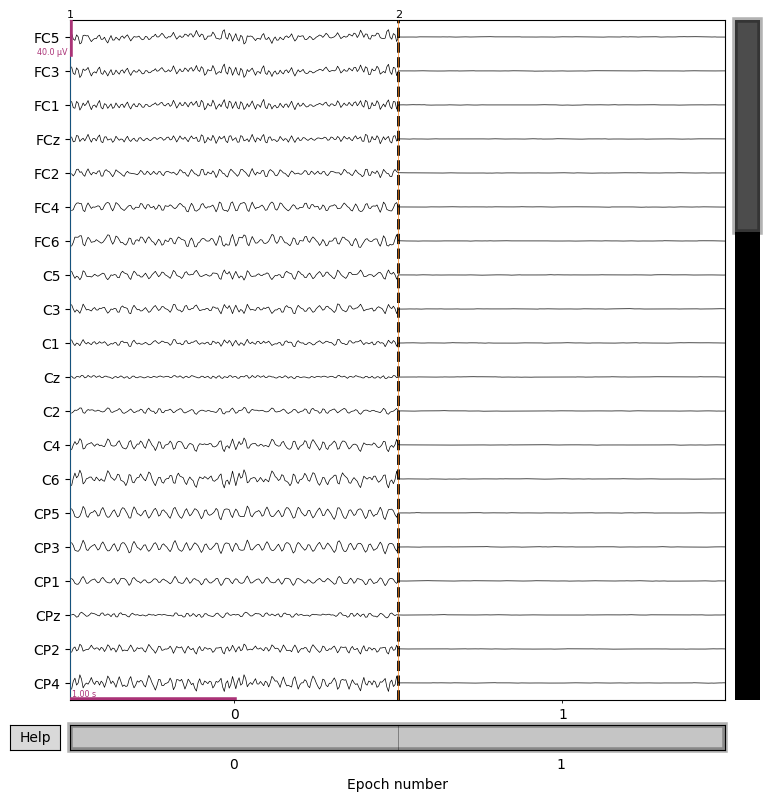

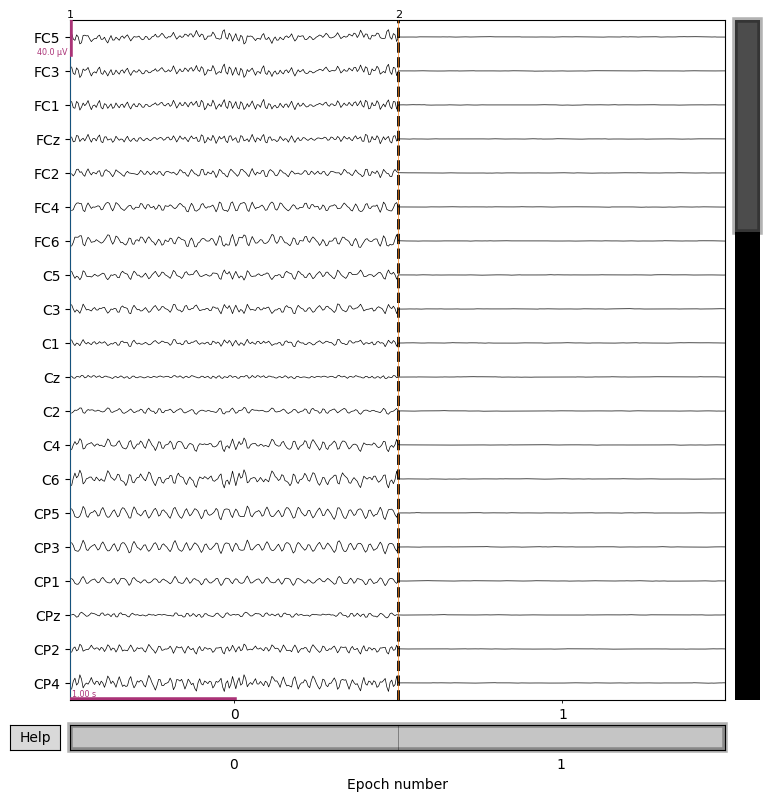

In [8]:
events = mne.read_events('./_0-1_200-2_eve.fif')
tmax = (len(stc_signal.times) - 1) / sfreq
epochs = mne.Epochs(
    raw,
    events,
    event_id=dict(signal=1, noise=2),
    tmin=0,
    tmax=tmax,
    baseline=None,
    preload=True,
)

print(epochs.drop_log_stats, tmax, raw)
assert len(epochs) == 2  # ensure that we got the two expected events

# Plot some of the channels of the simulated data that are situated above one
# of our simulated sources.
# Choose EEG channels instead of MEG gradiometers
picks = mne.pick_types(epochs.info, eeg=True, exclude="bads")  # Select only EEG channels

# Plot selected EEG channels
epochs.plot(picks=picks, events=True)


### Inverse And Forward

In [9]:
inv = make_inverse_operator(epochs.info, fwd, cov)

# Apply the inverse model to the trial that also contains the signal.
s = apply_inverse(epochs["signal"].average(), inv, method="eLORETA", pick_ori="normal")


Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.174517
    scale = 125525 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 5.7e-18 (2.2e-16 eps * 64 dim * 0.0004  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD 

In [15]:
# inv['src']
# fwd['src']
# cov['data']
epochs

<Epochs | 2 events (all good), 0 – 1.99 s (baseline off), ~286 kB, data loaded,
 'signal': 1
 'noise': 1>

### PCA

(20484, 200)
(68, 200)


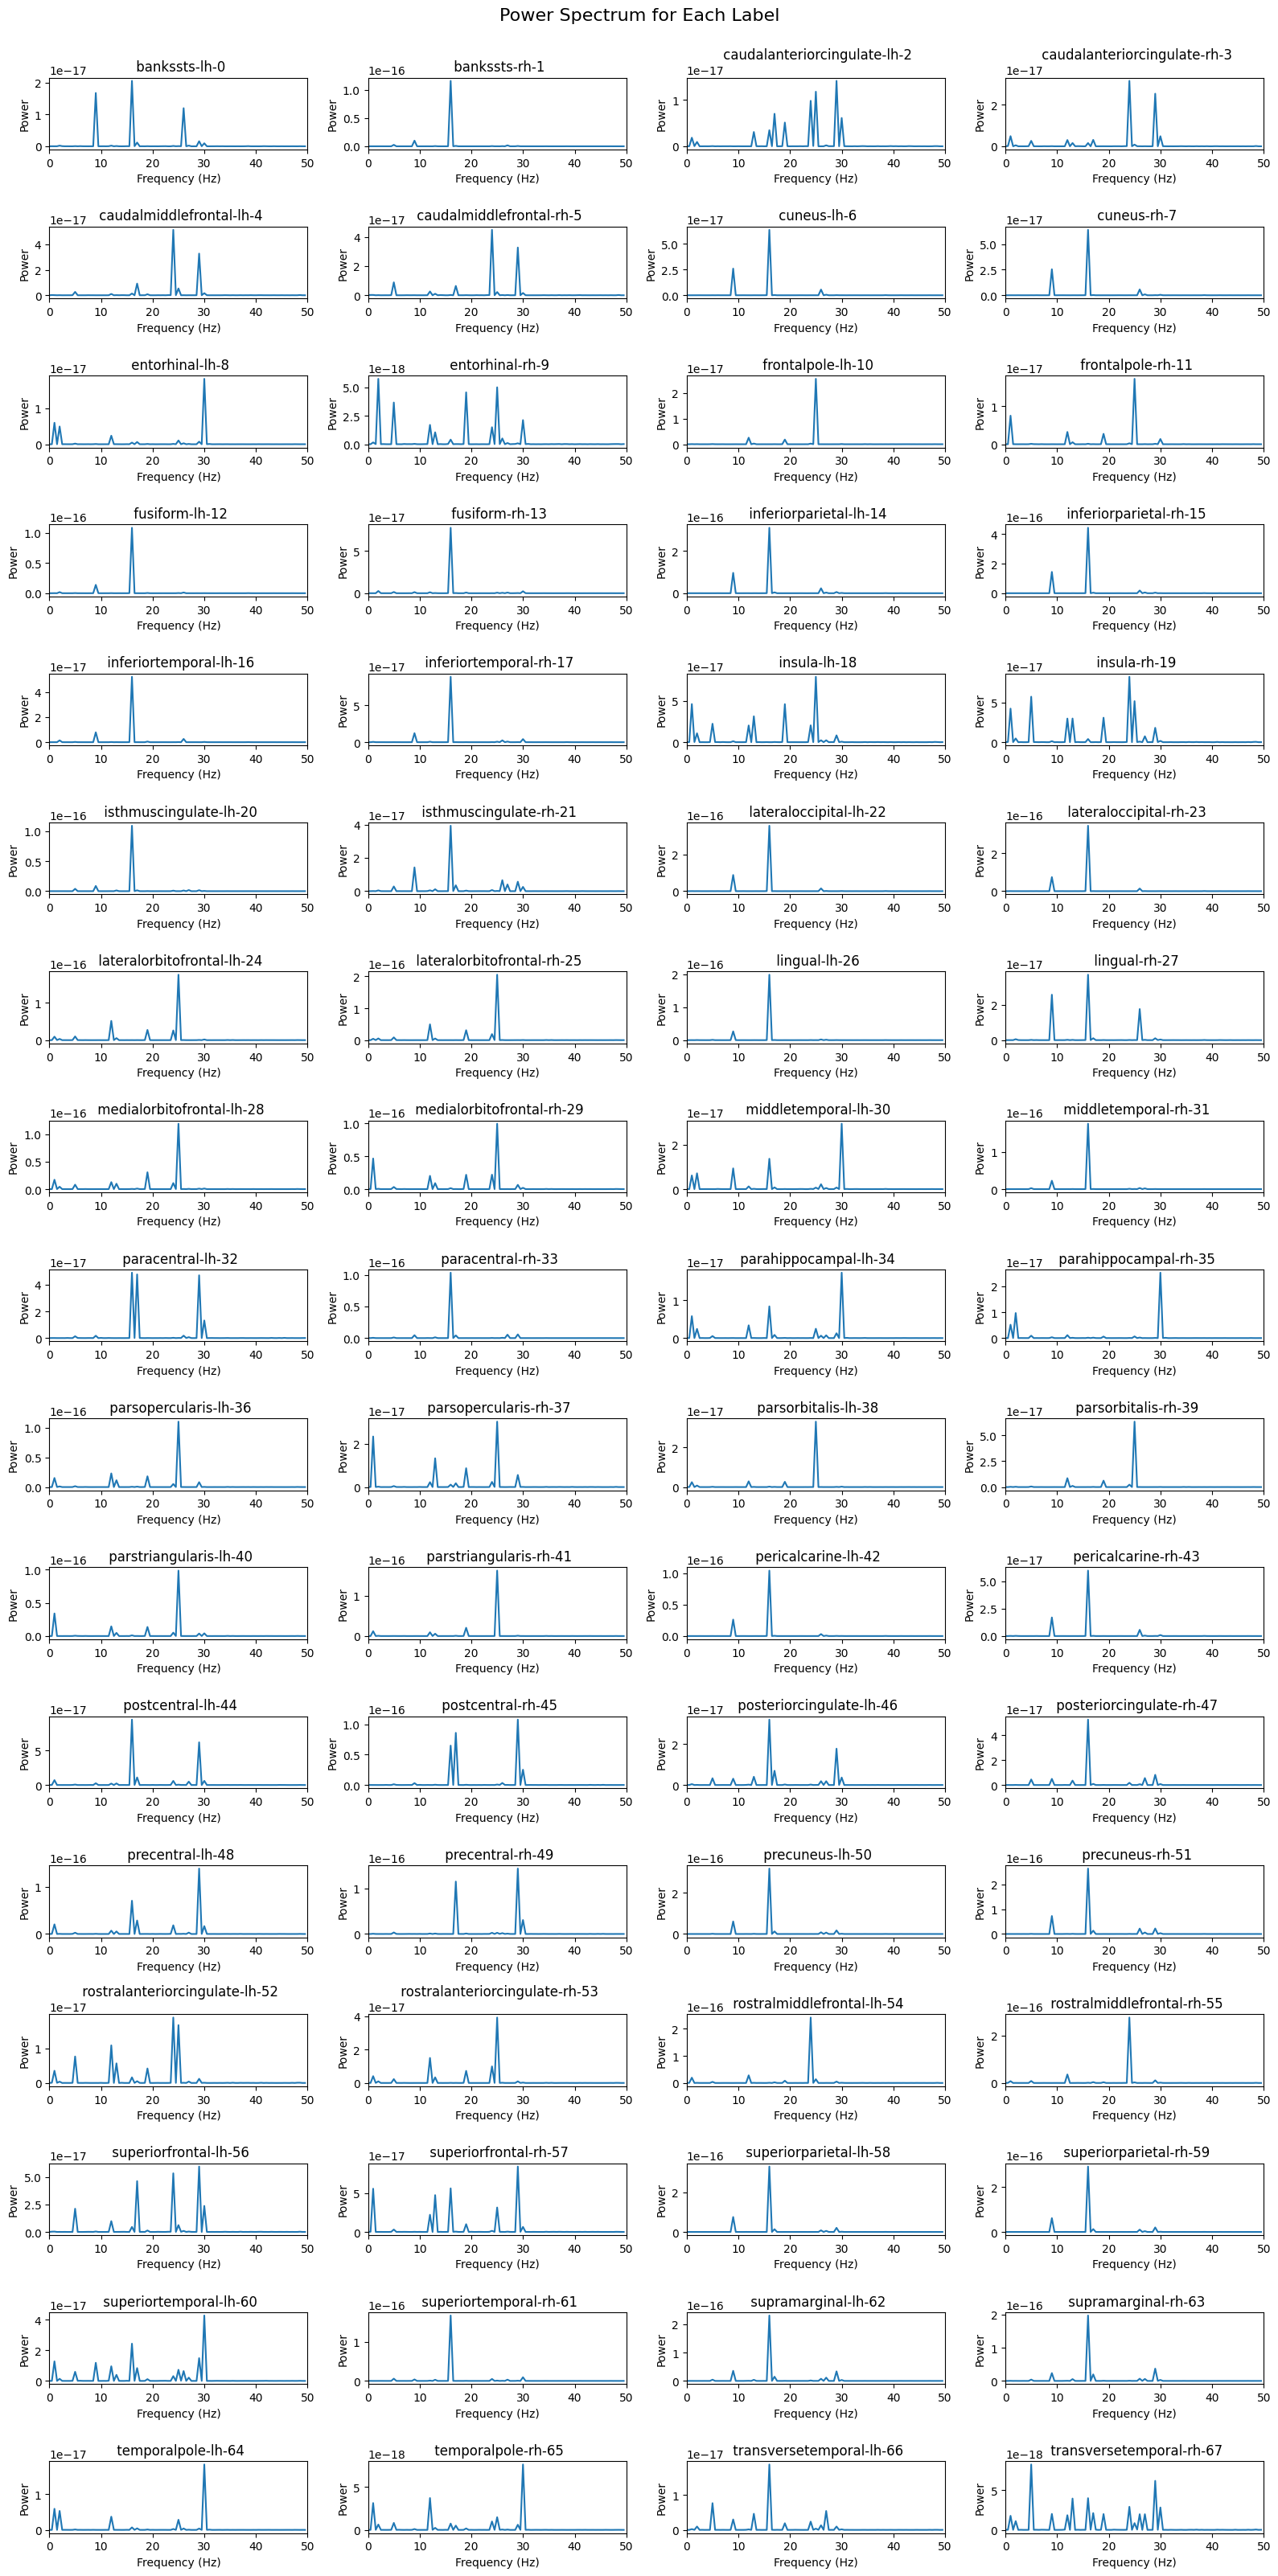

In [16]:
import numpy as np
import mne
from sklearn.decomposition import PCA

# 取得 stc_gen 內的數據 (6940, 100)
stc_data = s.data  # shape: (6940, 100)
print(stc_data.shape)

# 初始化 PCA
pca = PCA(n_components=1)  # 取前 3 個主成分

# 儲存降維後的信號
pca_time_series = []

# 針對每個 label 進行 PCA
for label in labels:
    # 獲取當前 label 內的頂點索引
    label_vertices = np.intersect1d(label.vertices, np.concatenate(s.vertices))

    # 若 label 內沒有任何有效頂點，跳過
    # print(label)
    if len(label_vertices) == 0:
        pca_time_series.append(np.zeros((3, 100)))  # 空的填充
        continue

    # 找出 stc_gen 內對應的 index
    label_idx = np.where(np.isin(np.concatenate(s.vertices), label_vertices))[0]

    # 取出該 label 內的 source time courses
    label_data = stc_data[label_idx, :]  # shape: (N_label_vertices, 100)

    # 使用 PCA 進行降維，取前 3 個主成分
    pca_result = pca.fit_transform(label_data.T).T  # shape: (3, 100)

    # 存入結果
    pca_time_series.append(pca_result)

# 轉換成 NumPy 陣列
pca_time_series = np.vstack(pca_time_series)  # shape: (68×3, 100)

# 輸出最終形狀
print(pca_time_series.shape)  # 期望結果: (68*3, 100)

import numpy as np
import matplotlib.pyplot as plt

# 假設你的降維數據是 (68, 100)，這裡用隨機數據替代
source_data = pca_time_series

# 設定 FFT 參數
sampling_rate = 100  # 假設取樣率為 100 Hz

# 計算 FFT
fft_result = np.fft.fft(source_data, axis=1)
power_spectrum = np.abs(fft_result) ** 2

# 計算頻率軸
freqs = np.fft.fftfreq(source_data.shape[1], d=1/sampling_rate)

# 只取正頻率部分
positive_freqs = freqs[:source_data.shape[1] // 2]
positive_power = power_spectrum[:, :source_data.shape[1] // 2]

# 畫出所有 labels 的 Power Spectrum
fig, axes = plt.subplots(17, 4, figsize=(16, 32))  # 8x9 網格排布 (68 個 labels)
fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)

for i, ax in enumerate(axes.flat):
    if i < 68:
        ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
        ax.set_title(f' {labels[i].name}-{i}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power')
        ax.set_xlim([0, sampling_rate / 2])  # Nyquist 頻率範圍
    else:
        ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉

plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
plt.show()


## Evaluate

In [17]:
for vertice, freq in zip(np.concatenate(simu_info[0]), simu_info[1]):
    label_index = labels_central_list.index(vertice)
    print(f"label:{labels[label_index].name}, index:{label_index}, vertices:{vertice}, freq={freq}")

# print(labels_central_list[19])
# print(126173 in fwd["src"][1]["vertno"])

stc_signal.vertices
simu_info[0]

label:temporalpole-lh, index:64, vertices:813, freq=30
label:cuneus-lh, index:6, vertices:1266, freq=9
label:entorhinal-lh, index:8, vertices:1343, freq=2
label:medialorbitofrontal-lh, index:28, vertices:4872, freq=19
label:lateraloccipital-lh, index:22, vertices:5285, freq=16
label:precentral-lh, index:48, vertices:6147, freq=16
label:parsorbitalis-lh, index:38, vertices:7602, freq=1
label:frontalpole-lh, index:10, vertices:7613, freq=25
label:lingual-rh, index:27, vertices:84, freq=26
label:superiorfrontal-rh, index:57, vertices:994, freq=29
label:caudalanteriorcingulate-rh, index:3, vertices:3420, freq=13
label:postcentral-rh, index:45, vertices:4643, freq=29
label:isthmuscingulate-rh, index:21, vertices:5066, freq=27
label:transversetemporal-rh, index:67, vertices:5369, freq=30
label:rostralmiddlefrontal-rh, index:55, vertices:7278, freq=24
label:precuneus-rh, index:51, vertices:7312, freq=16
label:precentral-rh, index:49, vertices:8128, freq=17
label:rostralanteriorcingulate-rh, i

[array([ 813, 1266, 1343, 4872, 5285, 6147, 7602, 7613], dtype=int64),
 array([  84,  994, 3420, 4643, 5066, 5369, 7278, 7312, 8128, 8293, 9184,
        9832], dtype=int64)]

In [ ]:
# 檢查 simulated source 正確

def do_fft(signals, sampling_rate = 100):

    # 計算 FFT
    stc_fft = np.fft.fft(signals, axis=1)
    stc_power_spectrum = np.abs(stc_fft) ** 2

    # 計算頻率軸
    freqs = np.fft.fftfreq(signals.shape[1], d=1/sampling_rate)

    # 只取正頻率部分
    positive_freqs = freqs[:signals.shape[1] // 2]
    positive_power = stc_power_spectrum[:, :signals.shape[1] // 2]

    return positive_power, positive_freqs

def show_fft(positive_power, positive_freqs, x, y, z):
    # 畫出所有 labels 的 Power Spectrum
    fig, axes = plt.subplots(x, y, figsize=(16, z))  
    fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)

    for i, ax in enumerate(axes.flat):
        if i < len(positive_power):
            ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
            ax.set_title(f' Channel-{i}')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.set_xlim([0, sampling_rate / 2])  # Nyquist 頻率範圍
        else:
            ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉

    plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
    plt.show()

stc_positive_power, stc_positive_freqs = do_fft(stc_signal.data)
show_fft(stc_positive_power, stc_positive_freqs, 3, 4, 8)


In [ ]:
eeg = epochs.get_data(picks)
eeg = raw.get_data(picks)
print(eeg.shape)
signals = eeg[0]
nosie = eeg[1]

eeg_positive_power, eeg_positive_freqs = do_fft(eeg)
show_fft(eeg_positive_power, eeg_positive_freqs, 24, 4, 32)

# Simulate Training Dataset

## Set Up

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import coherence, unit_impulse, welch

import mne
from mne.beamformer import apply_dics_csd, make_dics
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator, read_inverse_operator
from mne.simulation import add_noise, simulate_raw
from mne.time_frequency import csd_morlet

import numpy as np
import mne
from sklearn.decomposition import PCA

"""
====================== Parameters =============================
"""
## Simulate Param
snr = 20.0
signal_num = 10
sfreq = 100.0
n = 5.0
n_samp = int(round(n * sfreq))


"""========================== Load Setup files =========================="""
# We use the MEG and MRI setup from the MNE-sample dataset
data_path = sample.data_path(download=False)
subjects_dir = data_path / "subjects"

# Filenames for various files we'll be using
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-eeg-oct-6-fwd.fif"
cov_fname = meg_path / "sample_audvis-cov.fif"
fwd = mne.read_forward_solution(fwd_fname)
# Seed for the random number generator
rand = np.random.RandomState(42)

"""========================== Read Labels =========================="""

labels = mne.read_labels_from_annot("sample", subjects_dir=subjects_dir)
label_names = [label.name for label in labels] 

labels_central_list = []

hemi_to_ind = {"lh": 0, "rh": 1}
for i, label in enumerate(labels):
    # The `center_of_mass` function needs labels to have values.
    labels[i].values.fill(1.0)

    # Restrict the eligible vertices to be those on the surface under
    # consideration and within the label.
    surf_vertices = fwd["src"][hemi_to_ind[label.hemi]]["vertno"]
    restrict_verts = np.intersect1d(surf_vertices, label.vertices)
    com = labels[i].center_of_mass(
        subjects_dir=subjects_dir, restrict_vertices=restrict_verts, surf="white"
    )
    
    # Convert the center of vertex index from surface vertex list to Label's
    # vertex list.
    cent_idx = np.where(label.vertices == com)[0][0]

    labels_central_list.append(labels[i].vertices[cent_idx])

## Function Def

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import coherence, unit_impulse, welch

import mne
from mne.beamformer import apply_dics_csd, make_dics
from mne.datasets import sample, fetch_fsaverage
from mne.minimum_norm import apply_inverse, make_inverse_operator, read_inverse_operator
from mne.simulation import add_noise, simulate_raw
from mne.time_frequency import csd_morlet

import numpy as np
import mne
from sklearn.decomposition import PCA
import os
import json
from datetime import datetime
import time
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

class data_generator:
    def __init__(self,
            max_source_signal = 11,
            min_source_signal = 1,
            num_samples = 10,
            snr = 10.0,
            sfreq = 100.0,
            n = 2.0,
            n_pca = 3.0,
            random_seed = 42,    
            ):
        
        """
        Param: 
            max_source_signal: The maximum random number of source signal.
            min_source_signal: The minimum random number of simulated source signal.
            num_samples: The dataset size to be generate within one times.
            snr: The signal-to-noise ratio for simulation
            sfreq: The sampling size of the data.
            n: The signal's durations (second).

        """

        ## Simulate Param
        self.signal_num_range = (min_source_signal, max_source_signal)
        self.num_samples = num_samples
        self.snr = snr
        self.sfreq = sfreq
        self.n = n
        self.n_samp = int(round(self.n * self.sfreq))
        self.dir_path = "./simulate_data/"
        self.hemi_index = {'lh': 0, 'rh': 1}  # 左/右半球索引對應
        self.n_pca = n_pca

        """========================== Load Setup files =========================="""
        mne.set_log_level('ERROR')  # 或 'WARNING'，根據你想看到多少輸出
        # We use the MEG and MRI setup from the MNE-sample dataset
        self.data_path = sample.data_path(download=False)
        
        # self.subjects_dir = self.data_path / "subjects"
        # Filenames for various files we'll be using
        # self.raw_fname = self.meg_path / "sample_audvis_raw.fif"
        # self.fwd_fname = self.meg_path / "sample_audvis-eeg-oct-6-fwd.fif"
        # self.fwd = mne.read_forward_solution(self.fwd_fname, verbose='WARNING')

        self.subjects_dir = fetch_fsaverage(verbose=True)
        self.raw_fname = './test_raw.fif'
        self.fwd_fname = './test-fwd.fif'
        self.events_fname = './_0-1_200-2_eve.fif'
        self.fwd = mne.read_forward_solution(self.fwd_fname)
        self.info = mne.io.read_raw(self.raw_fname).resample(100).info

        # Seed for the random number generator
        # self.random_seed = random_seed
        self.rand = np.random.RandomState()

        """========================== Read Labels =========================="""

        labels = mne.read_labels_from_annot("", subjects_dir=self.subjects_dir)
        self.labels = labels[:-1]
        self.label_names = [label.name for label in self.labels] 

        self.labels_central_list = []

        # 從所有 labels 中收集 LH / RH 的 vertex index
        lh_label_vertices = np.concatenate([label.vertices for label in self.labels if label.hemi == 'lh'])
        rh_label_vertices = np.concatenate([label.vertices for label in self.labels if label.hemi == 'rh'])
        # 從 forward model 拿到 surface vertex index（source space）
        lh_surf_vertices = self.fwd["src"][0]["vertno"]
        rh_surf_vertices = self.fwd["src"][1]["vertno"]

        # 找出在 forward model 的 source space 中，也被 label 覆蓋的 vertices
        lh_overlap = np.intersect1d(lh_surf_vertices, lh_label_vertices)
        rh_overlap = np.intersect1d(rh_surf_vertices, rh_label_vertices)
        self.fwd_overlap_vertices = [lh_overlap, rh_overlap]

        hemi_to_ind = {"lh": 0, "rh": 1}
        for i, label in enumerate(self.labels):
            # The `center_of_mass` function needs labels to have values.
            self.labels[i].values.fill(1.0)

            # Restrict the eligible vertices to be those on the surface under
            # consideration and within the label.
            surf_vertices = self.fwd["src"][hemi_to_ind[label.hemi]]["vertno"]
            restrict_verts = np.intersect1d(surf_vertices, label.vertices)
            com = self.labels[i].center_of_mass(
                subjects_dir=self.subjects_dir, restrict_vertices=restrict_verts, surf="white"
            )
            
            # Convert the center of vertex index from surface vertex list to Label's
            # vertex list.
            cent_idx = np.where(label.vertices == com)[0][0]

            self.labels_central_list.append(self.labels[i].vertices[cent_idx])


    def coh_signal_gen(self, base_freq = 10.0):
        """Generate an oscillating signal.
        Inputs:
            base_frq: base freqency for simulation
            sfreq: sampling freqency
            n: sampling times (seconds)

        Returns
        -------
        signal : ndarray
            The generated signal.
        """
        
        times = np.arange(self.n_samp) / self.sfreq 

        t_rand = 0.001  # Variation in the instantaneous frequency of the signal
        std = 0.1  # Std-dev of the random fluctuations added to the signal
        n_times = len(times)

        # Generate an oscillator with varying frequency and phase lag.
        signal = np.sin(
            2.0
            * np.pi
            * (
                base_freq * np.arange(n_times) / self.sfreq
                + np.cumsum(t_rand * self.rand.randn(n_times))
            )
        )

        # Add some random fluctuations to the signal.
        signal += std * self.rand.randn(n_times)

        # Scale the signal to be in the right order of magnitude (~100 nAm)
        # for MEG data.
        signal *= 20e-9

        return signal

    def stc_signal_gen(self, signal_num=2):
        vertices = [[], []]  # 左半球、右半球的頂點索引
        data = []
        simu_freq = []

        hemi_index = {'lh': 0, 'rh': 1}  # 左/右半球索引對應
        
        # **確保選擇的頂點不重複**
        selected_vertices = set()  # 用來追蹤已選過的頂點

        for _ in range(signal_num):
            rand_freq = np.random.randint(1, 31)  # 避免 0 Hz
            simu_freq.append(rand_freq)
            
            # **隨機選擇一個未被選擇過的頂點**
            unused_vertices = list(set(self.labels_central_list) - selected_vertices)

            label_vertex = np.random.choice(unused_vertices)
            label_index = self.labels_central_list.index(label_vertex)
            hemi = self.labels[label_index].hemi  # 取得半球資訊
            selected_vertices.add(label_vertex)  # 加入已選清單

            # 產生信號
            signal = self.coh_signal_gen(rand_freq)

            # 加入對應的半球
            vertices[hemi_index[hemi]].append(label_vertex)
            data.append(signal)

        # **確保 `vertices` 內的頂點是遞增排序的，並轉換成 numpy array**
        vertices[0] = np.array(sorted(vertices[0]), dtype=np.int64)  # 左半球
        vertices[1] = np.array(sorted(vertices[1]), dtype=np.int64)  # 右半球

        # **確保 `data` 是 numpy array，並檢查形狀**
        data = np.array(data)

        # **檢查 `data.shape[0]` 是否等於 `len(vertices[0]) + len(vertices[1])`**
        expected_sources = len(vertices[0]) + len(vertices[1])
        if data.shape[0] != expected_sources:
            raise ValueError(f"Mismatch: data.shape[0]={data.shape[0]}, but expected {expected_sources}")

        # **建立 SourceEstimate**
        stc_signal = mne.SourceEstimate(
            data, vertices, tmin=0, tstep=1.0 / self.sfreq, subject="sample", verbose='WARNING'
        )
        stc_noise = stc_signal * 0.0

        return stc_signal, stc_noise, (vertices, simu_freq)

    def stc_signal_fillall(self, signal_num=2):
        # 取得每個 hemisphere 的 vertex index
        all_vertices = [s['vertno'] for s in self.fwd['src']]  # 這是一個長度為2的list: [lh_vertices, rh_vertices]

        # 建立全 0 的資料，shape = (n_vertices_total, n_times)
        n_lh = len(all_vertices[0])
        n_rh = len(all_vertices[1])
        # data_lh = np.zeros((n_lh, n_times))
        # data_rh = np.zeros((n_rh, n_times))
        data_lh = np.random.normal(0, 0.1, (n_lh, self.n_samp)) * 20e-10  # Gaussian noise
        data_rh = np.random.normal(0, 0.1, (n_rh, self.n_samp)) * 20e-10  # Gaussian noise
        data = [data_lh, data_rh]

        simu_freq = []
        vertices = []
        
        # **確保選擇的頂點不重複**
        selected_vertices_lh = set()  # 用來追蹤已選過的頂點
        selected_vertices_rh = set()
        selected_vertices_list = [selected_vertices_lh, selected_vertices_rh]

        for _ in range(signal_num):
            rand_freq = np.random.randint(1, 50)  # 避免 0 Hz
            simu_freq.append(rand_freq)

            rand_spherical = np.random.choice([0,1])

            # **隨機選擇一個未被選擇過的頂點**
            unused_vertices = list(set(self.fwd_overlap_vertices[rand_spherical]) - selected_vertices_list[rand_spherical])

            label_vertex = np.random.choice(unused_vertices)
            selected_vertices_list[rand_spherical].add(label_vertex)  # 加入已選清單
            
            vertices.append(label_vertex)

            # 產生信號
            signal = self.coh_signal_gen(rand_freq)

            # 找到vertex在all_vertices中的Index
            idx = all_vertices[rand_spherical].tolist().index(label_vertex)
            data[rand_spherical][idx, :] = signal

        data = np.concatenate(data)

        # **建立 SourceEstimate**
        stc_signal = mne.SourceEstimate(
            data, all_vertices, tmin=0, tstep=1.0 / self.sfreq, subject="sample", verbose='WARNING'
        )
        stc_noise = stc_signal * 0.0

        return stc_signal, stc_noise, (vertices, simu_freq)

    def generate_dataset(self, dataset_num):
        """
        Generates multiple EEG and source datasets, storing each in a separate directory.

        Parameters:
        dir_path (str): The parent directory to save datasets.
        num_samples (int): The number of EEG-source samples to generate.
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        dataset_dir = os.path.join(self.dir_path, f"dataset_seedsource_{self.num_samples}_{self.snr}_{timestamp}")
        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)

        # Save dataset parameters
        params = {
            "signal_num_range": f"{self.signal_num_range[0]}-{self.signal_num_range[1]}",
            "sampling_freq": self.sfreq,
            "num_samples": self.n_samp,
            "snr": self.snr,
            # "random_seed": self.random_seed,
            "forward_pth": self.fwd_fname,
            "forward_model": str(self.fwd),
            "raw_fname": self.raw_fname,
            "info": str(self.info),
        }
        
        param_file = os.path.join(dataset_dir, "params.txt")
        with open(param_file, "w") as f:
            json.dump(params, f, indent=4)

        for d_n in range(dataset_num):
            all_eeg_data = []
            all_source_data = []
            for i in tqdm(range(self.num_samples), desc=f"Generating dataset:{d_n}"):
                # Generate EEG and source data
                rand_num = self.rand.randint(self.signal_num_range[0], self.signal_num_range[1])
                """
                如果要換source種類 記得修改
                """
                src_data, tgt_data, _ = self.generate_seed_data(signal_num=rand_num)
                
                # Append to list
                all_eeg_data.append(src_data)
                all_source_data.append(tgt_data)
                
                # print(f"Dataset {i} generated")

            # Convert to numpy arrays (consider using object dtype if shapes vary)
            all_eeg_data = np.array(all_eeg_data)
            all_source_data = np.array(all_source_data)

            # Save all data to .npy
            np.save(os.path.join(dataset_dir, f"all_eeg_data_{d_n}.npy"), all_eeg_data)
            np.save(os.path.join(dataset_dir, f"all_source_data_{d_n}.npy"), all_source_data)

            print(f"Datasets:{d_n} generated and saved successfully.")

    def generate_seed_data(self, signal_num = 1):
        
        stc_signal, stc_noise, gen_config = self.stc_signal_fillall(signal_num=signal_num)

        picks = mne.pick_types(self.info, eeg=True, stim=True, exclude=())
        mne.pick_info(self.info, picks, copy=False, verbose='WARNING')  # modifies info in-place

        cov = mne.cov.make_ad_hoc_cov(self.info, verbose='WARNING')
        cov["data"] *= (20.0 / self.snr) ** 2  # Scale the noise to achieve the desired SNR

        # Simulate the raw data, with a lowpass filter on the noise
        stcs = [
            (stc_signal, unit_impulse(self.n_samp, dtype=int) * 1),
            (stc_noise, unit_impulse(self.n_samp, dtype=int) * 2),
        ] 
        # this raw variable is not the same as self.raw
        _raw = simulate_raw(self.info, stcs, forward=self.fwd, verbose=None)
        add_noise(_raw, cov, iir_filter=[4, -4, 0.8], random_state=self.rand, verbose=None)

        events = mne.read_events(self.events_fname)
        tmax = (len(stc_signal.times) - 1) / self.sfreq
        epochs = mne.Epochs(
            _raw,
            events,
            event_id=dict(signal=1, noise=2),
            tmin=0,
            tmax=tmax,
            baseline=None,
            reject=dict(eeg=40e-0),
            preload=True,
            verbose=None
        )
        assert len(epochs) == 2   # ensure that we got the two expected events
        picks = mne.pick_types(epochs.info, eeg=True, exclude="bads")

        tgt_pca_ = self.do_pca(stc_signal, self.n_pca)
        tgt_positive_power, _ = do_fft(tgt_pca_)

        eeg_data = epochs.get_data(picks)[0]
        src_positive_power, _ = do_fft(eeg_data)

        # print(f"src data shape: {src_positive_power.shape}")
        # print(f"tgt data shape: {tgt_positive_power.shape}")
        
        return src_positive_power, tgt_positive_power, gen_config

    def generate_inverse_data(self, signal_num):
        
        stc_signal, stc_noise, _ = self.stc_signal_gen(signal_num=signal_num)

        picks = mne.pick_types(self.info, eeg=True, stim=True, exclude=())
        mne.pick_info(self.info, picks, copy=False, verbose='WARNING')  # modifies info in-place

        cov = mne.cov.make_ad_hoc_cov(self.info, verbose='WARNING')
        cov["data"] *= (20.0 / self.snr) ** 2  # Scale the noise to achieve the desired SNR

        # Simulate the raw data, with a lowpass filter on the noise
        stcs = [
            (stc_signal, unit_impulse(self.n_samp, dtype=int) * 1),
            (stc_noise, unit_impulse(self.n_samp, dtype=int) * 2),
        ] 
        # this raw variable is not the same as self.raw
        _raw = simulate_raw(self.info, stcs, forward=self.fwd, verbose=None)
        add_noise(_raw, cov, iir_filter=[4, -4, 0.8], random_state=self.rand, verbose=None)

        events = mne.read_events(self.events_fname)
        tmax = (len(stc_signal.times) - 1) / self.sfreq
        epochs = mne.Epochs(
            _raw,
            events,
            event_id=dict(signal=1, noise=2),
            tmin=0,
            tmax=tmax,
            baseline=None,
            reject=dict(eeg=40e-0),
            preload=True,
            verbose=None
        )
        assert len(epochs) == 2   # ensure that we got the two expected events
        picks = mne.pick_types(epochs.info, eeg=True, exclude="bads")
        # epochs.set_eeg_reference("average", projection=True)

        inv = make_inverse_operator(epochs.info, self.fwd, cov, verbose=None)

        # Apply the inverse model to the trial that also contains the signal.
        s = apply_inverse(epochs["signal"].average(), inv, method="eLORETA", pick_ori="normal", verbose=None)

        pca_times_series = self.do_pca(s, self.n_pca)

        eeg_data = epochs.get_data(picks)[0]
        src_positive_power, _ = do_fft(eeg_data)
        
        tgt_positive_power, _ = do_fft(pca_times_series)
        # print(f"src data shape: {src_positive_power.shape}")
        # print(f"tgt data shape: {tgt_positive_power.shape}")

        return src_positive_power, tgt_positive_power

    def do_pca(self, s, n_components = 3):
        # 取得 stc_gen 內的數據 (6940, 100)
        stc_data = s.data  # shape: (6940, 100)

        pca = PCA(n_components=n_components)  # 取前 3 個主成分

        pca_time_series = []

        for label in self.labels:
            hemi = self.hemi_index[label.hemi]

            label_vertices = np.intersect1d(label.vertices, s.vertices[hemi])
            assert len(label_vertices) > 0

            label_idx = np.where(np.isin(s.vertices[hemi], label_vertices))[0]

            if hemi == 1:
                label_idx = label_idx + len(s.vertices[hemi])

            label_data = stc_data[label_idx, :]  # shape: (N_label_vertices, 100)

            pca_result = pca.fit_transform(label_data.T).T  # shape: (3, 100)

            pca_time_series.append(pca_result)

        pca_time_series = np.vstack(pca_time_series)  # shape: (68×3, 100)

        return pca_time_series
    
    def find_labels(self, vertices_idx):
        for index, label in enumerate(self.labels):
            if vertices_idx in label.vertices:
                return label.name, index

def do_fft(signals, sampling_rate = 100):

    # 計算 FFT
    stc_fft = np.fft.fft(signals, axis=1)
    stc_power_spectrum = np.abs(stc_fft) ** 2

    # 計算頻率軸
    freqs = np.fft.fftfreq(signals.shape[1], d=1/sampling_rate)

    # 只取正頻率部分
    positive_freqs = freqs[:signals.shape[1] // 2]
    positive_power = stc_power_spectrum[:, :signals.shape[1] // 2]

    return positive_power, positive_freqs

def show_fft(positive_power, sampling_rate = 100, x=17, y=4, z=32):

    # 只取正頻率部分
    positive_freqs = np.linspace(0, 49.5, 100)  # 產生 100 個從 0 到 49.5 的點

    # 畫出所有 labels 的 Power Spectrum
    fig, axes = plt.subplots(x, y, figsize=(16, z))  
    fig.suptitle("Power Spectrum for Each Label", fontsize=16, y=1)
    
    for i, ax in enumerate(axes.flat):
        if i < len(positive_power):
            ax.plot(positive_freqs, positive_power[i], label=f'Label {i+1}')
            ax.set_title(f' Channel-{i}')
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power')
            ax.set_xlim([0, sampling_rate/2])  # Nyquist 頻率範圍
        else:
            ax.axis("off")  # 超出 68 個 labels 的 subplot 關閉

    plt.tight_layout(rect=[0, 0, 1, 1])  # 調整間距，避免標題擠壓圖像
    plt.show()




## Main Code

In [ ]:
if __name__ == '__main__':
    dg = data_generator(
        max_source_signal = 1000,
        min_source_signal = 100,
        num_samples = 1,
        snr = 1e6,
        n_pca = 3,
        )
    # dg.generate_dataset(10)

    src, tgt, gen_config = dg.generate_seed_data(1)
    print(dg.labels)
    # print(tgt.shape)
    # for i in range(10):
    #     print(f"Source:{dg.find_labels(gen_config[0][i])}, Hz:{gen_config[1][i]}")
    # # Plot eeg power
    # show_fft(src, x = 15, y = 4, z = 28)
    # # Plot source power 
    # show_fft(tgt, x = 17, y = 4, z = 32)

In [ ]:
import mne
from mne.beamformer import apply_dics_csd, make_dics
from mne.datasets import sample, fetch_fsaverage
from mne.minimum_norm import apply_inverse, make_inverse_operator, read_inverse_operator
from mne.simulation import add_noise, simulate_raw
from mne.time_frequency import csd_morlet

fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir
labels = mne.read_labels_from_annot("", subjects_dir=subjects_dir)
labels = labels[:-1]
label_names = [label.name for label in labels] 

# label_names



In [ ]:
import os
import json

# Define a valid save directory
save_dir = './'  # or specify a folder like './saved_labels/'

# Make sure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Define save path correctly
save_path = os.path.join(save_dir, "label_names.json")

# Save your label names
with open(save_path, 'w', encoding='utf-8') as f:
    json.dump(label_names, f, ensure_ascii=False, indent=2)

print(f"Saved label names to {save_path}")